## Guitar Chord Classifier
*Brian Cassriel & Zack Rosenthal*

This project implements a Convolutional Neural Network (CNN) to classify guitar chords from audio recordings. The model is trained on spectrograms generated from waveform audio files of various guitar chords.

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

The dataset that we are using is the IDMT-SMT-GUITAR_V2 dataset, specifically "dataset4", which contains recordings of songs played on a guitar and annotations about chords played at different timestamps.

The dataset is not useful to us in its current state, so we will use its data to create a new dataset with only single chord waveforms in folders with chord labels.

In [4]:
dataset4_path = './IDMT-SMT-GUITAR_V2/dataset4' 

chord_label_dataset_path = "./chord_clips"
os.makedirs(chord_label_dataset_path, exist_ok=True)

print("Source root:", dataset4_path)
print("Destination root:", chord_label_dataset_path)

Source root: ./IDMT-SMT-GUITAR_V2/dataset4
Destination root: ./chord_clips


The following set of functions create catgeorized clips of chords as new files from full-length audio files with annotation.

In [5]:
import soundfile as sf
import librosa
import pandas as pd

def populate_chord_clips(dataset_path):
    clip_count = 0

    for dirpath, dirnames, filenames in os.walk(dataset_path):
        if os.path.basename(dirpath).lower() != "audio":
            continue
        print("Scanning:", dirpath)
        for fname in filenames:
            if not fname.lower().endswith(".wav"):
                continue
            annotation_fname = fname[:-4] + ".csv"
            annotation_path = os.path.join(os.path.dirname(dirpath), "annotation/chords", annotation_fname)
            audio_path = os.path.join(dirpath, fname)
            clips, sr = get_chord_clips_from_wav(audio_path, annotation_path)
            print(f"  Found {len(clips)} chord clips in {fname}")
            save_clips_as_single_files(clips, fname, chord_label_dataset_path, sr)
            clip_count += len(clips)
    print("Created", clip_count, "chord clips.")

def get_chord_clips_from_wav(wav_filename: str, annotation_filename: str) -> str | None:
    audio, sr = librosa.load(wav_filename)
    clips = []
    annotation_csv = pd.read_csv(annotation_filename)
    for (index, row) in annotation_csv.iterrows():
        chord_label = get_chord_label(row)
        if chord_label is None:
            continue
        start_sample, end_sample = get_sample_bounds(annotation_csv, index, row, chord_label, audio, sr)
        clip_audio = audio[start_sample:end_sample]
        clips.append((clip_audio, chord_label))
    return clips, sr

def save_clips_as_single_files(clips, original_fname, destination_root, sr):
    for idx, (clip_audio, chord_label) in enumerate(clips):
        dst_dir = os.path.join(destination_root, chord_label)
        os.makedirs(dst_dir, exist_ok=True)
        
        base_name = original_fname[:-4]
        dst_filename = f"{base_name}_clip{idx}.wav"
        dst_path = os.path.join(dst_dir, dst_filename)
        sf.write(dst_path, clip_audio, samplerate=sr)

def get_chord_label(row):
    # The chord label is always the first character after the colon. If the chord is flat, we include that as well.
    chord_descriptor = row.iloc[1]
    if len(row) < 2 or ':' not in str(chord_descriptor):
        return None
    chord_name = chord_descriptor.split(":")[1]
    chord_label = chord_name[0]
    if (chord_label == 'N'):
        return None
    if (len(chord_name) > 1 and chord_name[1] == 'b'):
        chord_label = chord_label + 'b'
    return chord_label

def get_sample_bounds(annotation_csv, index, row, chord_label, audio, sr):
    time_sec = row.iloc[0]
    start_sample = int(time_sec * sr)
    end_sample = get_end_sample(annotation_csv, index, chord_label, audio, sr)
    return start_sample, end_sample

def get_end_sample(annotation_csv, index, chord_label, audio, sr):
    if (index + 1) < len(annotation_csv):
        # Look ahead to find the next chord label. That will be the end time for this chord.
        next_index = index + 1
        current_chord = chord_label
        while next_index < len(annotation_csv):
            next_row = annotation_csv.iloc[next_index]
            if len(next_row) < 2 or ':' not in str(next_row.iloc[1]):
                next_index += 1
                continue
            next_chord = next_row.iloc[1].split(":")[1].split("/")[0]
            if next_chord != current_chord:
                end_sample = int(next_row.iloc[0] * sr)
                break
            next_index += 1
        else:
            # No different chord found, use end of audio.
            end_sample = len(audio)
    else:
        end_sample = len(audio)
    return end_sample

In [6]:
populate_chord_clips(dataset4_path)

Scanning: ./IDMT-SMT-GUITAR_V2/dataset4/acoustic_mic/slow/pop/audio
  Found 8 chord clips in pop_1_130BPM.wav
  Found 15 chord clips in pop_7_60BPM.wav
  Found 11 chord clips in pop_4_100BPM.wav
  Found 7 chord clips in pop_3_130BPM.wav
  Found 15 chord clips in pop_6_90BPM.wav
  Found 11 chord clips in pop_8_85BPM.wav
  Found 9 chord clips in pop_5_78BPM.wav
  Found 8 chord clips in pop_2_120BPM.wav
Scanning: ./IDMT-SMT-GUITAR_V2/dataset4/acoustic_mic/slow/rock_blues/audio
  Found 15 chord clips in rock_2_100BPM.wav
  Found 95 chord clips in rock_7_100BPM.wav
  Found 95 chord clips in rock_8_100BPM.wav
  Found 15 chord clips in rock_5_100BPM.wav
  Found 10 chord clips in rock_6_100BPM.wav
  Found 11 chord clips in rock_3_100BPM.wav
  Found 7 chord clips in rock_4_110BPM.wav
  Found 7 chord clips in rock_1_100BPM.wav
Scanning: ./IDMT-SMT-GUITAR_V2/dataset4/acoustic_mic/slow/metal/audio
  Found 6 chord clips in metal_3_100BPM.wav
  Found 5 chord clips in metal_6_110BPM.wav
  Found 5 cho

In [7]:
train_dataset, test_dataset = tf.keras.utils.audio_dataset_from_directory(
    directory=chord_label_dataset_path,
    batch_size=None,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both'
)
print("Chord classes:", train_dataset.class_names)

Found 2158 files belonging to 12 classes.
Using 1727 files for training.
Using 431 files for validation.
Chord classes: ['A', 'Ab', 'B', 'Bb', 'C', 'D', 'Db', 'E', 'Eb', 'F', 'G', 'Gb']


The following code snippit defines a function to convert waveform audio to a spectrogram. The spectrograms are then used in the CNN.

In [8]:
spectrogram_shape = (128, 128, 1)

def get_spectrogram(waveform):
    waveform = tf.squeeze(waveform, axis=-1)
    spectrogram = tf.signal.stft(
        waveform,
        frame_length=255,
        frame_step=128
    )
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]  # add channel dim
    spectrogram = tf.image.resize(spectrogram, [spectrogram_shape[0], spectrogram_shape[1]])

    return spectrogram


In [9]:
def make_spec_ds(ds, batch_size=64):
    ds = ds.map(
        lambda audio, label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_spectrogram_ds = make_spec_ds(train_dataset)
test_spectrogram_ds = make_spec_ds(test_dataset)

for specs, labels in train_spectrogram_ds.take(1):
    print("Spectrogram batch shape:", specs.shape)
    print("Labels batch shape:", labels.shape)
    break


Spectrogram batch shape: (64, 128, 128, 1)
Labels batch shape: (64,)


Convolutional Neural Network that takes in spectrograms of guitar chords and classifies them into chord categories.

In [10]:
num_classes = len(train_dataset.class_names)

model = Sequential([
    tf.keras.layers.Input(shape=spectrogram_shape),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,612 (12.61 MB)

 Trainable params: 3,305,612 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import csv

EPOCHS = 6
history = model.fit(
    train_spectrogram_ds,
    validation_data=test_spectrogram_ds,
    epochs=EPOCHS
)

Epoch 1/6
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 360ms/step - accuracy: 0.1992 - loss: 2.3676 - val_accuracy: 0.2900 - val_loss: 2.2469
Epoch 2/6
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 340ms/step - accuracy: 0.3046 - loss: 2.0625 - val_accuracy: 0.3155 - val_loss: 2.0541
Epoch 3/6
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 330ms/step - accuracy: 0.3972 - loss: 1.7935 - val_accuracy: 0.3527 - val_loss: 1.9216
Epoch 4/6
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 336ms/step - accuracy: 0.4945 - loss: 1.5023 - val_accuracy: 0.4316 - val_loss: 1.7040
Epoch 5/6
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 327ms/step - accuracy: 0.5860 - loss: 1.2482 - val_accuracy: 0.4849 - val_loss: 1.6051
Epoch 6/6
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 337ms/step - accuracy: 0.6815 - loss: 0.9555 - val_accuracy: 0.5684 - val_loss: 1.5651
Metrics saved to training_metrics.csv


The following snippet creates a confusion matrix for the test set:

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


2025-12-01 16:38:47.590132: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


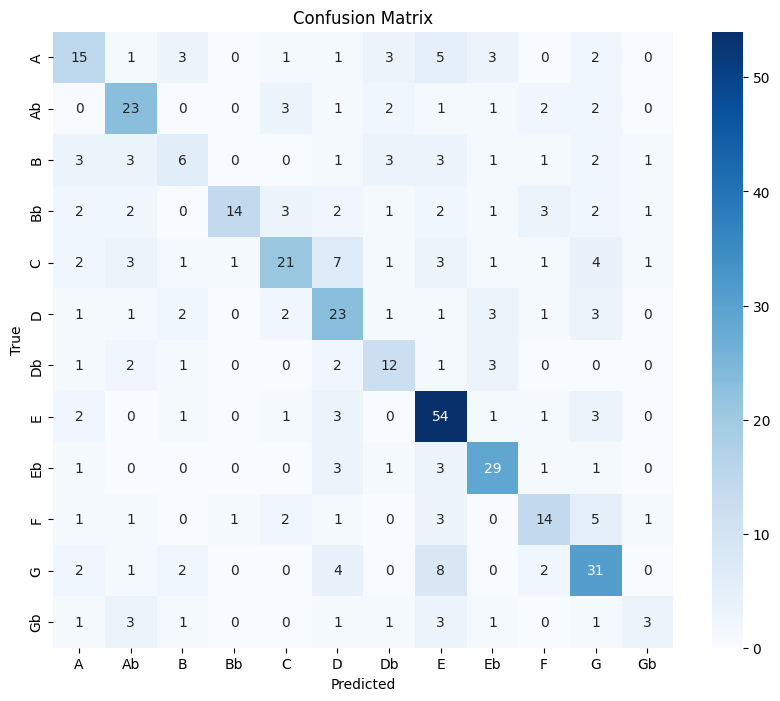

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = []
y_pred = []
for specs, labels in test_spectrogram_ds:
    predictions = model.predict(specs)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())
test_conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_dataset.class_names, 
            yticklabels=train_dataset.class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

The following snippet defines two methods that can be used to run our model on real, unprocessed clips of guitar chords.

In [13]:
def load_and_preprocess(filepath):
    audio_binary = tf.io.read_file(filepath)
    audio, sr = tf.audio.decode_wav(audio_binary)
    audio = tf.squeeze(audio, axis=-1)
    audio = audio[:16000] # Pad/trim to 16000 samples (1 sec)
    audio = tf.pad(audio, [[0, max(0, 16000 - tf.shape(audio)[0])]])
    audio = tf.expand_dims(audio, axis=-1)
    spec = get_spectrogram(audio)
    spec = tf.expand_dims(spec, axis=0)
    return spec

def predict_chord(filepath):
    spec = load_and_preprocess(filepath)
    pred = model.predict(spec)
    idx = np.argmax(pred)
    confidence = float(np.max(pred))

    class_names = train_dataset.class_names
    print("File:", filepath)
    print("Predicted label:", class_names[idx])
    print("Confidence:", confidence)